In [7]:
!pip install ninja
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Wed Feb 12 07:42:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8       

# Convolution - filter in constant memory

In [50]:
%%writefile convolution_constant_memory.cu
#include <iostream>
#include <cuda_runtime.h>
#include <torch/extension.h>

using namespace std;

#define STRINGFY(str) #str
#define TORCH_BINDING_COMMON_EXTENSION(func) \
  m.def(STRINGFY(func), &func, STRINGFY(func));

# define BLOCKSIZE 32
# define MAX_FILTER_RADIUS 7
__constant__ float Filter[(2*MAX_FILTER_RADIUS+1) * (2*MAX_FILTER_RADIUS+1)];

#define CHECK_CUDA_CALL(err)                                                \
    {                                                                       \
        if (err != cudaSuccess)                                             \
        {                                                                   \
            fprintf(stderr, "CUDA error in file %s at line %d: %s\n",       \
                    __FILE__, __LINE__, cudaGetErrorString(err));           \
            exit(EXIT_FAILURE);                                             \
        }                                                                   \
    }


__global__
void convolution_constant_memory(float* input, float* output, int rows, int cols, int filter_radius){
    int o_row = blockDim.y * blockIdx.y + threadIdx.y;
    int o_col = blockDim.x * blockIdx.x + threadIdx.x;

    float prod_accumulation = 0.0;

    for (int f_row=0; f_row < 2*filter_radius + 1; ++f_row){
        for (int f_col=0; f_col < 2*filter_radius + 1; ++f_col){
            int in_row = o_row - filter_radius + f_row;
            int in_col = o_col - filter_radius + f_col;
            if (in_row > -1 && in_row < rows && in_col > -1 && in_col < cols){
                //filter radius might not be equal to MAX_FILTER_RADIUS - so Filter accessed as 1D array
                prod_accumulation += Filter[f_row * (2*filter_radius + 1) + f_col] * input[in_row * cols + in_col];
            }
        }
    }
    if (o_row > -1 && o_row < rows && o_col > -1 && o_col < cols){
      output[o_row * cols + o_col] = prod_accumulation;
    }
}

torch::Tensor convolution(torch::Tensor input, torch::Tensor filter){
    TORCH_CHECK(input.device().is_cpu(), "Input tensor must be on CPU");
    TORCH_CHECK(filter.device().is_cpu(), "Filter tensor must be on CPU");
    TORCH_CHECK(input.dim() == 2, "Input tensor must be 2D");
    TORCH_CHECK(filter.dim() == 2, "Filter tensor must be 2D");
    TORCH_CHECK(filter.size(0) == filter.size(1), "Filter must be square shaped");
    TORCH_CHECK(filter.size(0) % 2 == 1, "Filter must have odd sized edge");
    TORCH_CHECK(filter.size(0) <= MAX_FILTER_RADIUS * 2 + 1, "Filter must be smaller than MAX_FILTER_RADIUS");

    int rows = input.size(0); int cols = input.size(1);
    input = input.cuda();
    auto output = torch::zeros({rows, cols}, input.options());
    float* filter_d;
    cudaMemcpyToSymbol(Filter, filter.data_ptr<float>(), filter.numel()*sizeof(float));

    int thread_x = BLOCKSIZE; int thread_y = BLOCKSIZE;
    dim3 block_size(thread_x, thread_y);

    int block_x = (cols + thread_x - 1)/ thread_x;
    int block_y = (rows + thread_y - 1)/ thread_y;
    dim3 grid_size(block_x, block_y);

    convolution_constant_memory<<<grid_size, block_size>>>(
                                      input.data_ptr<float>(),
                                      output.data_ptr<float>(),
                                      rows,
                                      cols,
                                      filter.size(0)/2
                                      );
    return output.cpu();
}

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  TORCH_BINDING_COMMON_EXTENSION(convolution)
}

Overwriting convolution_constant_memory.cu


In [51]:
import torch
import numpy as np
from PIL import Image

from torch.utils.cpp_extension import load
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

lib = load(
    name="convolution",
    sources=["/content/convolution_constant_memory.cu"]
)

2.5.1+cu124
True
12.4


/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [52]:
# load image and change to rectangular size greyscale tensor
image = Image.open("/content/lena.png")
gray_image = image.convert('L')
grey_array_np = np.array(gray_image)[:, 50:-50] # make rectangular for robust testing
img_tensor = torch.tensor(grey_array_np, dtype=torch.float32) # inefficient storage but works for testing

array([[167, 175, 168, ..., 119, 122, 121],
       [167, 175, 168, ..., 119, 122, 121],
       [167, 175, 168, ..., 119, 122, 121],
       ...,
       [182, 181, 182, ...,  90,  84,  85],
       [178, 182, 180, ...,  90,  84,  87],
       [178, 182, 180, ...,  90,  84,  87]], dtype=uint8)
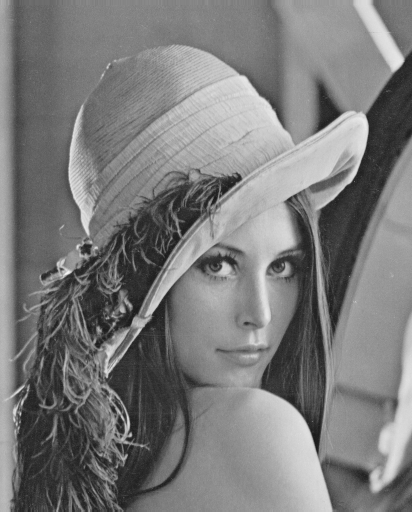

In [53]:
grey_array_np

In [60]:
filter = torch.ones(1,1) # for a kernel of size 1, the output image should be same as input
output_tensor = lib.convolution(img_tensor, filter)
output_np = output_tensor.to(dtype=torch.uint8).numpy()
np.array_equal(grey_array_np, output_np)

True

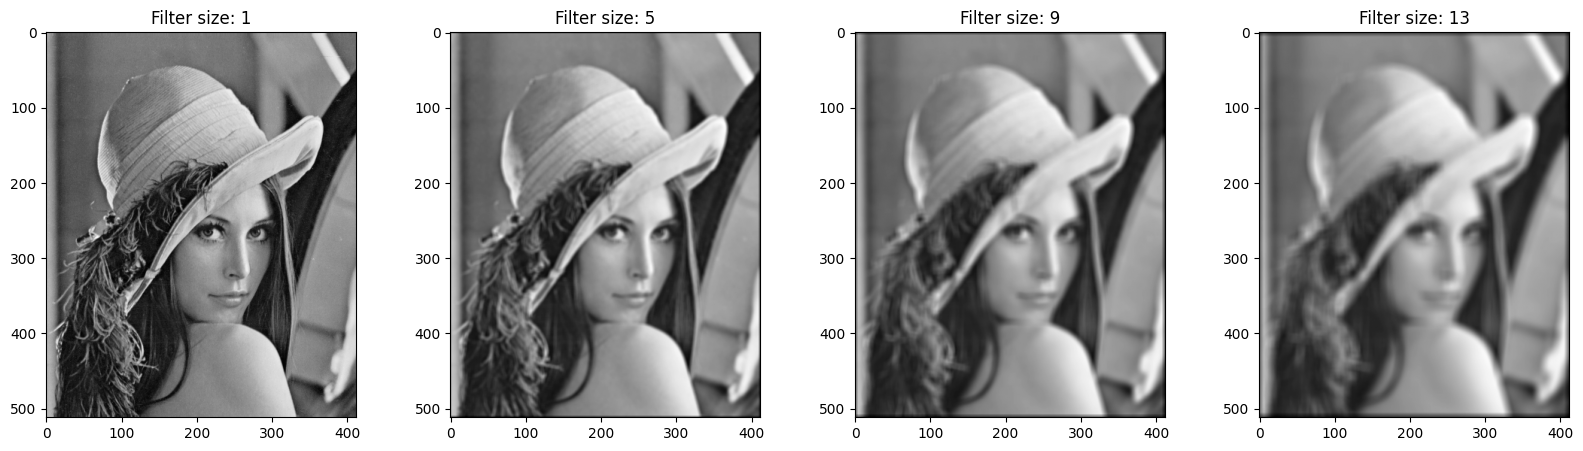

In [74]:
MAX_FILTER_RADIUS = 7
images = []
filter_sizes = []
for filter_radius in range(0,MAX_FILTER_RADIUS+1, 2):
  filter_size = filter_radius * 2 + 1
  filter = torch.ones(filter_size, filter_size) / (filter_size * filter_size)
  output_tensor = lib.convolution(img_tensor, filter)
  output_np = output_tensor.to(dtype=torch.uint8).numpy()
  images.append(output_np)
  filter_sizes.append(filter_size)

from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, len(images), figsize=(20, 5))

for i in range(len(images)):
  axs[i].imshow(images[i], cmap='gray')
  axs[i].set_title(f"Filter size: {filter_sizes[i]}")
